## Executive Summary
The goal of this analysis is to acquire IMDB data from Kaggle regarding movie ratings, cleaning and analyzing it to create supervised Machine Learning models. These models were used to predict movie ratings based on a set of features.


### Project Overview
- The tasks for my project were planned using this [Trello board](https://trello.com/b/b89f5ARw/predicting-movie-ratings)
- Python scripts were used to automate the process of acquiring, preparing and exploring the data
- The data was cleaned by replacing null values and dropping duplicates. 
- These steps were taken to create the best performing model:
    - Check correlation of features with target
    - Drop variables with object dtypes
- Statistical analyses tested the following hypotheses:
    - Do movies with runtime less than 150 minutes have lower ratings?
- The data was split into train, test and split dataframes before modeling to avoid data leakage and maintain data integrity
- Since our target variable, Rating, is continuous, we used the following regression algorithms to create models with the intention of beating the baseline:
    - OLS Regression
    - Lasso + Lars
    - Tweedie Regressor GLM
    - 2nd degree Polynomial Regression
- The best model was fitted on the test data to predict movie ratings

### Key Takeaways
- The number of votes and movie ranking were found to be the best drivers of movie rating
- Most variables were not highly correlated with each other
- There were some outliers in the data in runtime, gross income, and number of votes
    - Based on model performance, we decided not to remove outliers
- The Root Mean Squared Error (RMSE) and R squared were utilized as metrics to evaluate a model's performance
- The baseline median's RMSE of 0.34 points was utilized as the RMSE to beat
- The Root Mean Squared Error (RMSE) and R squared were utilized as metrics to evaluate a model's performance
- All models beat the baseline R-squared of 0
- Lasso Lars model had the same RMSE as the baseline but a negative R squared
- The best performing model is the OLS Linear Regression Model with RMSE of 4.153175e-15 (realistically 0) and R squared of 1. 
- The OLS Linear Regression model also explains 100% of the variance in movie ratings while the baseline explains 0%.
- We fit the OLS Linear Regression Model on our test data and evaluated its performance.
- The RMSE lowered slightly but the R-squared remained at 1.

### Data Dictionary
You can find the data dictionary detailing all the variables used in the data [here](https://github.com/mariamnaqvi/predicting-movie-ratings)


In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# for splitting the df
from sklearn.model_selection import train_test_split

from scipy import stats

# import to remove warnings
import warnings
warnings.filterwarnings("ignore")

# custom module imports
import acquire as aq
import prepare as pr
import explore as ex

# import modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score


# Acquire

In [2]:
# acquire data

df = aq.get_data()

In [3]:
# quick look 

df.head()

,Ranking,IMDByear,IMDBlink,Title,Date,RunTime,Genre,Rating,Score,Votes,Gross,Director,Cast1,Cast2,Cast3,Cast4
0,1,1996,/title/tt0076759/,Star Wars,1977,121,"Action, Adventure, Fantasy",8.6,90.0,1254781,322.74,George Lucas,Mark Hamill,Harrison Ford,Carrie Fisher,Alec Guinness
1,2,1996,/title/tt0111161/,The Shawshank Redemption,1994,142,Drama,9.3,80.0,2407245,28.34,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler
2,3,1996,/title/tt0117951/,Trainspotting,1996,93,Drama,8.1,83.0,645186,16.50,Danny Boyle,Ewan McGregor,Ewen Bremner,Jonny Lee Miller,Kevin McKidd
3,4,1996,/title/tt0114814/,The Usual Suspects,1995,106,"Crime, Mystery, Thriller",8.5,77.0,1010775,23.34,Bryan Singer,Kevin Spacey,Gabriel Byrne,Chazz Palminteri,Stephen Baldwin
4,5,1996,/title/tt0108598/,The Wrong Trousers,1993,30,"Animation, Short, Comedy",8.3,NaN,51747,NaN,Nick Park,Peter Sallis,Peter Hawkins,NaN,NaN


In [9]:
# summary stats

df.describe()

,Ranking,IMDByear,Date,RunTime,Rating,Score,Votes,Gross
count,4893.000000,4893.000000,4893.000000,4893.000000,4893.000000,4893.000000,4.893000e+03,4893.000000
mean,117.814429,2008.075618,1982.458206,128.275087,8.188637,83.984059,5.445629e+05,75.143675
std,72.313512,7.201061,21.680967,29.716175,0.337203,10.301275,4.701390e+05,104.014928
min,1.000000,1996.000000,1925.000000,73.000000,6.100000,61.000000,9.401000e+03,0.010000
25%,55.000000,2002.000000,1967.000000,107.000000,8.000000,77.000000,1.623390e+05,6.390000
50%,115.000000,2008.000000,1988.000000,124.000000,8.100000,85.000000,3.836450e+05,32.000000
75%,179.000000,2014.000000,1999.000000,142.000000,8.400000,92.000000,8.061440e+05,101.160000
max,250.000000,2020.000000,2019.000000,238.000000,9.300000,100.000000,2.407245e+06,936.660000


In [4]:
# summarize the df

aq.summarize(df)

The IMDB dataframe has 6250 rows and 16 columns.

-------------------
There are total of 1652 missing values in the entire dataframe.

-------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6250 entries, 0 to 6249
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Ranking   6250 non-null   int64  
 1   IMDByear  6250 non-null   int64  
 2   IMDBlink  6250 non-null   object 
 3   Title     6250 non-null   object 
 4   Date      6250 non-null   int64  
 5   RunTime   6250 non-null   int64  
 6   Genre     6250 non-null   object 
 7   Rating    6250 non-null   float64
 8   Score     5399 non-null   float64
 9   Votes     6250 non-null   int64  
 10  Gross     5465 non-null   float64
 11  Director  6250 non-null   object 
 12  Cast1     6250 non-null   object 
 13  Cast2     6250 non-null   object 
 14  Cast3     6242 non-null   object 
 15  Cast4     6242 non-null   object 
dtypes: float64(3), int64(5), object

## Takeaways

- good size data set with some nulls
- Score, Gross, Cast 3 and 4 have nulls
- Rating is the target variable
- dtypes look as expected

# Prepare

The prep function in the prepare script will help in cleaning the df. As part of data prep, we will perform the following actions:
- check for duplicate rows
- take care of nulls in Score, Gross, Cast 3 and Cast 4
- split the df into train, validate and test sets

The following steps will explain how we decided how to handle the nulls for each column.

### handling nulls in Score 

This action was performed as part of the prep function.

In [4]:
# check how many nulls 

df.Score.value_counts(dropna=False)

NaN      851
90.0     287
84.0     267
86.0     239
94.0     238
85.0     223
91.0     217
77.0     204
88.0     204
96.0     200
100.0    197
98.0     194
80.0     188
83.0     178
92.0     177
79.0     160
89.0     158
97.0     157
87.0     152
75.0     135
66.0     133
82.0     118
95.0     117
76.0     102
73.0      98
78.0      93
72.0      93
74.0      91
65.0      89
99.0      87
70.0      86
93.0      71
69.0      68
68.0      67
62.0      56
64.0      52
71.0      51
67.0      50
81.0      42
63.0      31
61.0      29
Name: Score, dtype: int64

<AxesSubplot:xlabel='Score'>

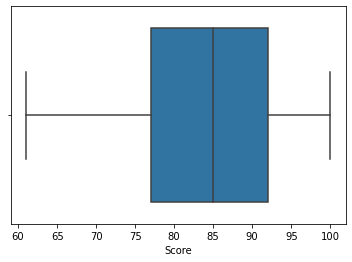

In [8]:
# check for outliers

sns.boxplot(x='Score', data=df)

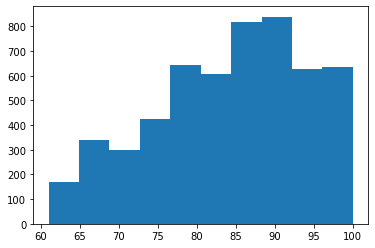

In [9]:
# visualize distribution 

df.Score.hist()
plt.grid(False)

- The Score variable has more movies with ratings higher than 75 than lower
- There do not seem to be many outliers. 
- We replaced the null values with the median score.

### handling nulls in Gross

In [13]:
# find how many nulls

df.Gross.value_counts(dropna=False)

NaN      785
4.36      86
0.06      51
5.32      50
0.01      50
        ... 
13.54      1
45.88      1
31.84      1
1.53       1
11.50      1
Name: Gross, Length: 584, dtype: int64

<AxesSubplot:xlabel='Gross'>

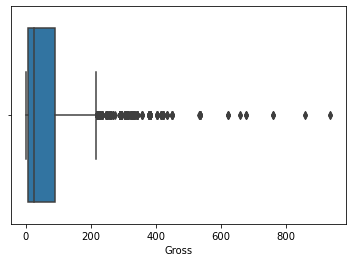

In [14]:
# check for outliers

sns.boxplot(x='Gross', data=df)

- The boxplot shows show upper outliers. 

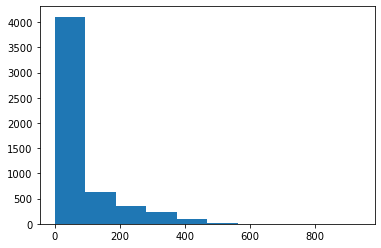

In [15]:
# visualize distribution 

df.Gross.hist()
plt.grid(False)

- The distribution seems left skewed possibly due to the outliers.
- We replaced the nulls in Gross with the median value as median is resistant to outliers.

### handling nulls in Cast 3 and Cast 4

In [19]:
df[df.Cast3.isnull()]

,Ranking,IMDByear,IMDBlink,Title,Date,RunTime,Genre,Rating,Score,Votes,Gross,Director,Cast1,Cast2,Cast3,Cast4
4,5,1996,/title/tt0108598/,The Wrong Trousers,1993,30,"Animation, Short, Comedy",8.3,85.0,51747,26.24,Nick Park,Peter Sallis,Peter Hawkins,NaN,NaN
85,86,1996,/title/tt0104361/,A Grand Day Out,1989,23,"Animation, Short, Adventure",7.8,85.0,32153,26.24,Nick Park,Peter Sallis,Peter Hawkins,NaN,NaN
278,29,1997,/title/tt0108598/,The Wrong Trousers,1993,30,"Animation, Short, Comedy",8.3,85.0,51747,26.24,Nick Park,Peter Sallis,Peter Hawkins,NaN,NaN
435,186,1997,/title/tt0104361/,A Grand Day Out,1989,23,"Animation, Short, Adventure",7.8,85.0,32153,26.24,Nick Park,Peter Sallis,Peter Hawkins,NaN,NaN
533,34,1998,/title/tt0108598/,The Wrong Trousers,1993,30,"Animation, Short, Comedy",8.3,85.0,51747,26.24,Nick Park,Peter Sallis,Peter Hawkins,NaN,NaN
726,227,1998,/title/tt0104361/,A Grand Day Out,1989,23,"Animation, Short, Adventure",7.8,85.0,32153,26.24,Nick Park,Peter Sallis,Peter Hawkins,NaN,NaN
794,45,1999,/title/tt0108598/,The Wrong Trousers,1993,30,"Animation, Short, Comedy",8.3,85.0,51747,26.24,Nick Park,Peter Sallis,Peter Hawkins,NaN,NaN
1038,39,2000,/title/tt0108598/,The Wrong Trousers,1993,30,"Animation, Short, Comedy",8.3,85.0,51747,26.24,Nick Park,Peter Sallis,Peter Hawkins,NaN,NaN


- The nulls in Cast 3 seem to be all be for the same 2 movies.
- The movies have different IMDB years and the rank for each year.
- It seems Cast 3 and Cast 4 are nulls for those movies because there are only 2 actors in the cast of these movies.
- The cast columns have too many different actors for us to one hot encode.
- We will move forward without replacing the nulls and just drop the cast columns for now.
    - This action is performed as part of the prep function.

In [5]:
df = pr.prep_data(df)

There are no duplicate rows in your dataset.
----------------
There are 1357 rows with null values in your dataset - these will be replaced.
----------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4893 entries, 0 to 6249
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Ranking   4893 non-null   int64  
 1   IMDByear  4893 non-null   int64  
 2   IMDBlink  4893 non-null   object 
 3   Title     4893 non-null   object 
 4   Date      4893 non-null   int64  
 5   RunTime   4893 non-null   int64  
 6   Genre     4893 non-null   object 
 7   Rating    4893 non-null   float64
 8   Score     4893 non-null   float64
 9   Votes     4893 non-null   int64  
 10  Gross     4893 non-null   float64
 11  Director  4893 non-null   object 
 12  Cast1     4893 non-null   object 
 13  Cast2     4893 non-null   object 
dtypes: float64(3), int64(5), object(6)
memory usage: 573.4+ KB


The above prep function cleans and returns the original df. As seen from the info printed by the function, there are no more nulls in the dataframe and Cast 3 and Cast 4 columns have been dropped. We will move on to splitting our data after univariate exploration. 

In [6]:
# look at shape of new df

df.shape

(4893, 14)

### Univariate Exploration 

In [7]:
# define categorical and continuous variables

cat_vars = ['IMDByear','Genre']

cont_vars = ['Ranking','RunTime','Rating','Votes','Gross']

Bar Plot of IMDByear


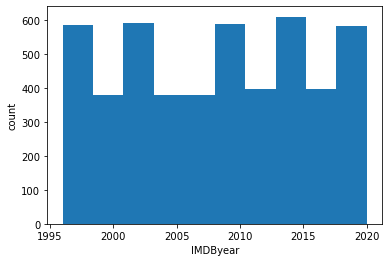

Bar Plot of Genre


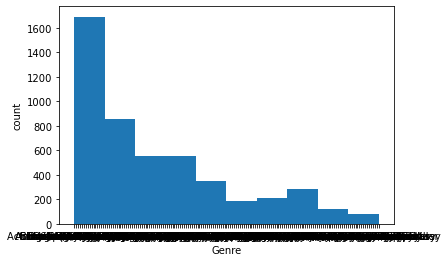

Distribution of Ranking


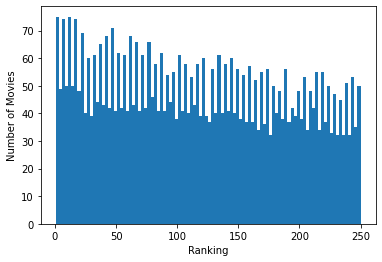

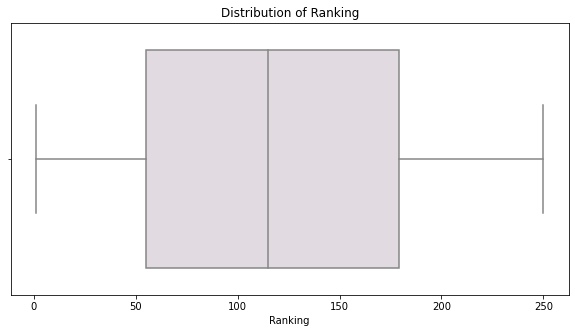

Distribution of RunTime


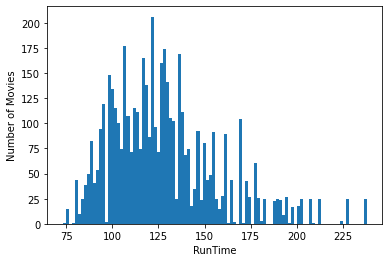

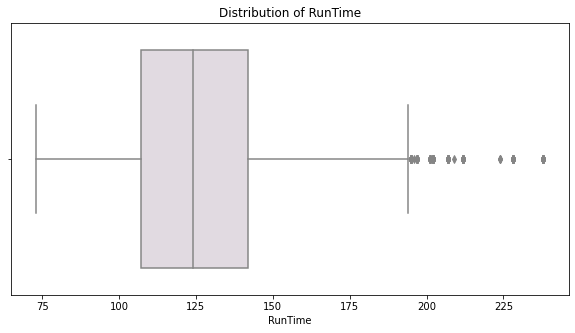

Distribution of Rating


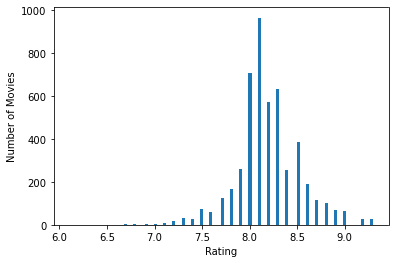

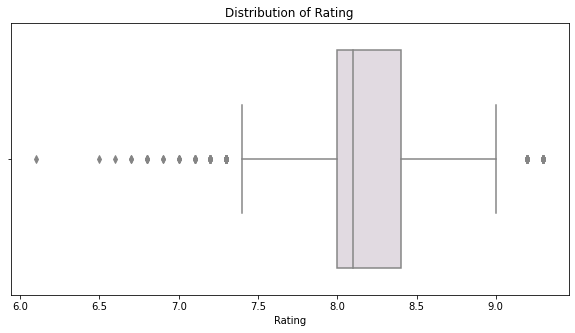

Distribution of Votes


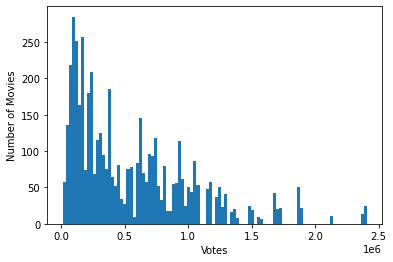

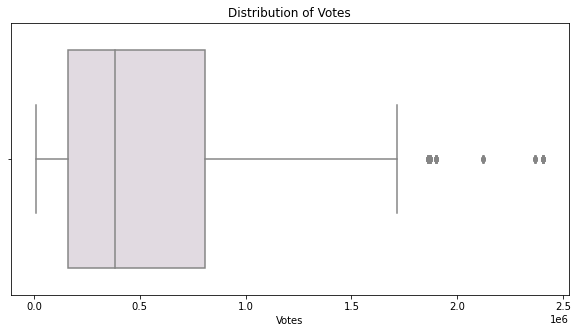

Distribution of Gross


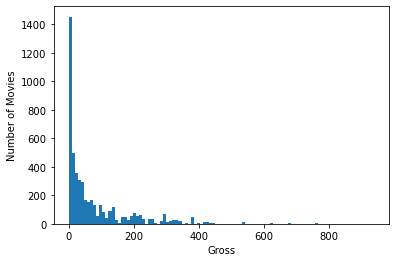

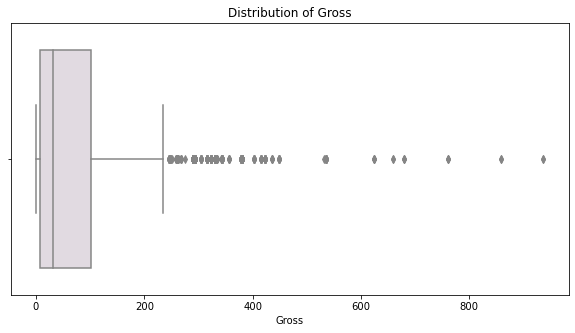

In [8]:
# call the function from explore script

ex.explore_univariate(df, cat_vars, cont_vars)

- The target variable of Rating looks fairly normally distirbuted.
- There are some outliers in certain variables causing their distributions to be skewed. 
- We can apply a robust scaler to reduce the effect of outliers. 
- At this time we will proceed without doing nothing to the outliers.
- After univariate exploration, we will split the original df into train, validate and test splits before moving on to bivariate and multivariate exploration. 

In [8]:
# call the split function from prepare script

train, validate, test = pr.split_data(df)

Shape of train split: (2739, 14)
----------------
Shape of test split: (1175, 14)
----------------
Shape of validate split: (979, 14)
----------------


- All the splits have different number of rows but the same number of columns which is what we are looking for. 

### Bivariate Exploration

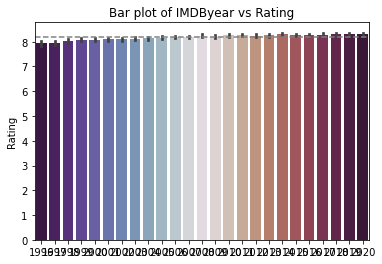

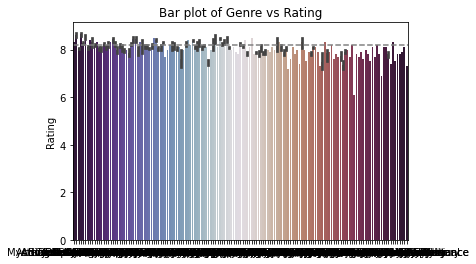

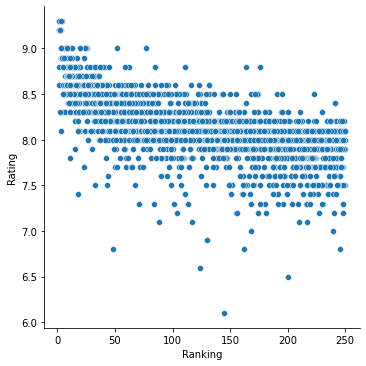

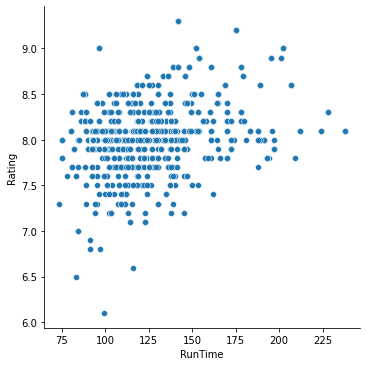

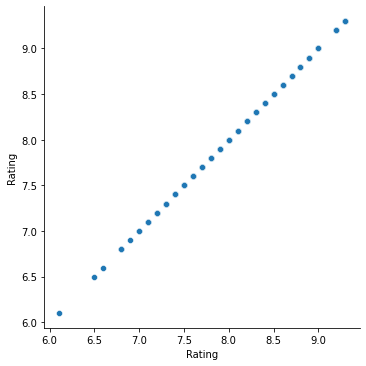

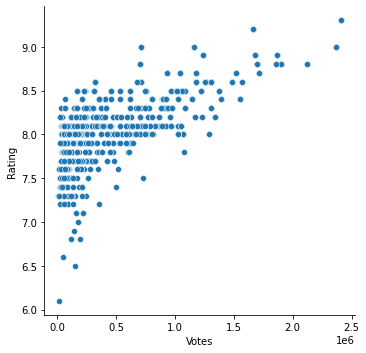

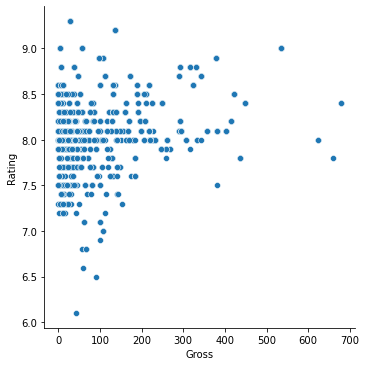

In [12]:
# call function from explore script

ex.explore_bivariate(train, 'Rating', cat_vars, cont_vars)

### Takeaways

- There is not much distinction between ratings based on genre or year
- Movies that rank higher seem to have lower ratings
- Movies with shorter runtimes seem to have higher ratings
- higher votes = higher Rating

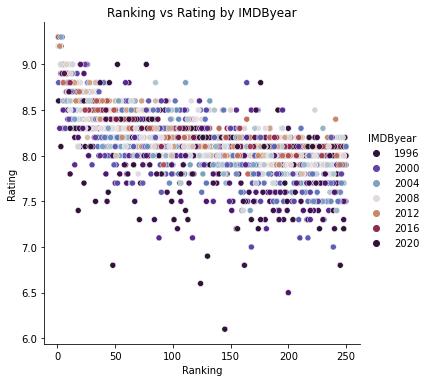

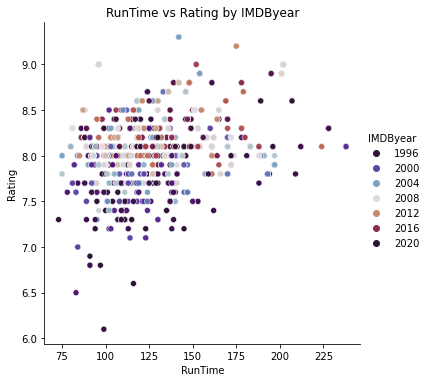

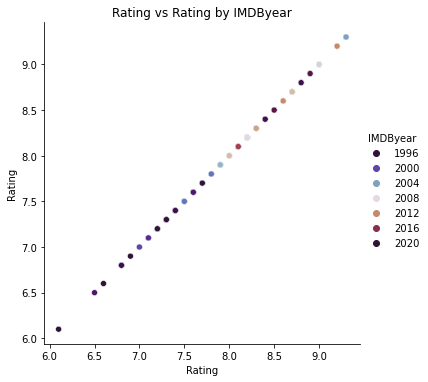

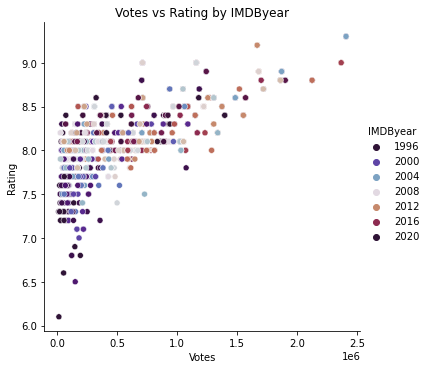

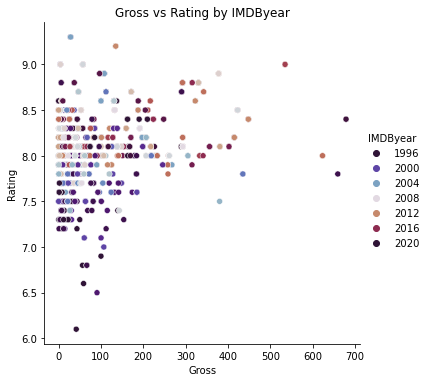

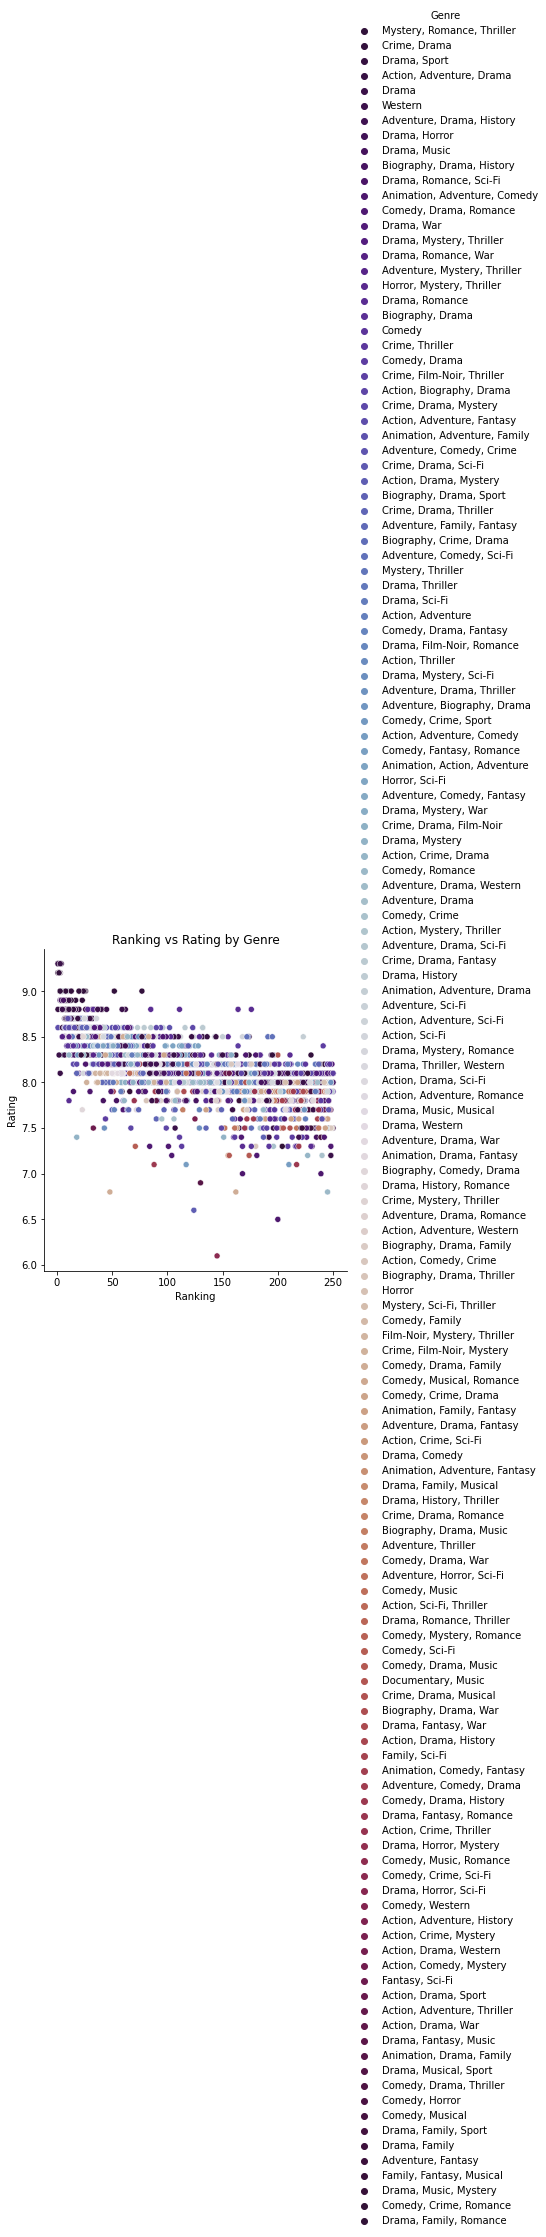

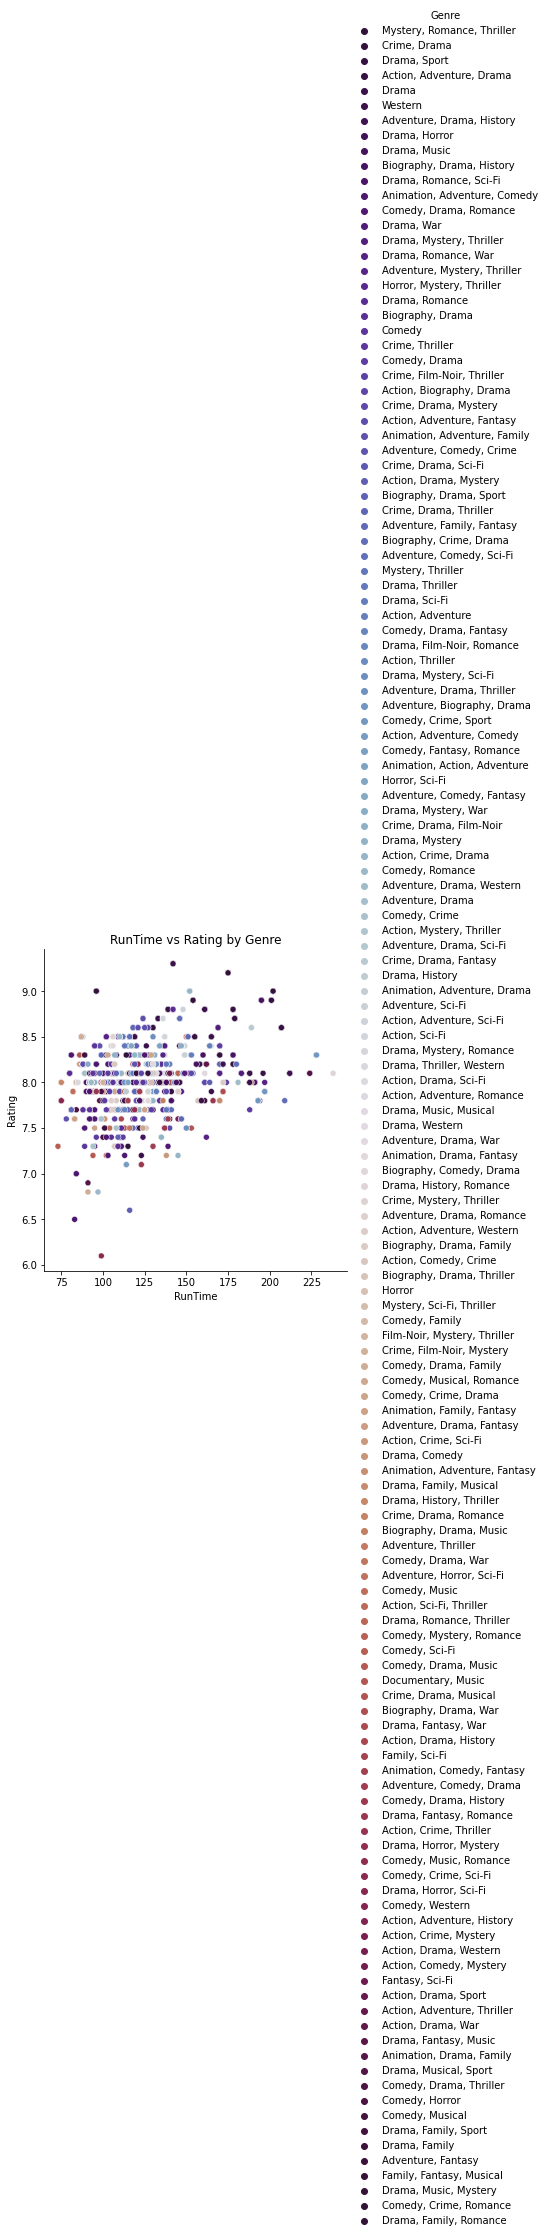

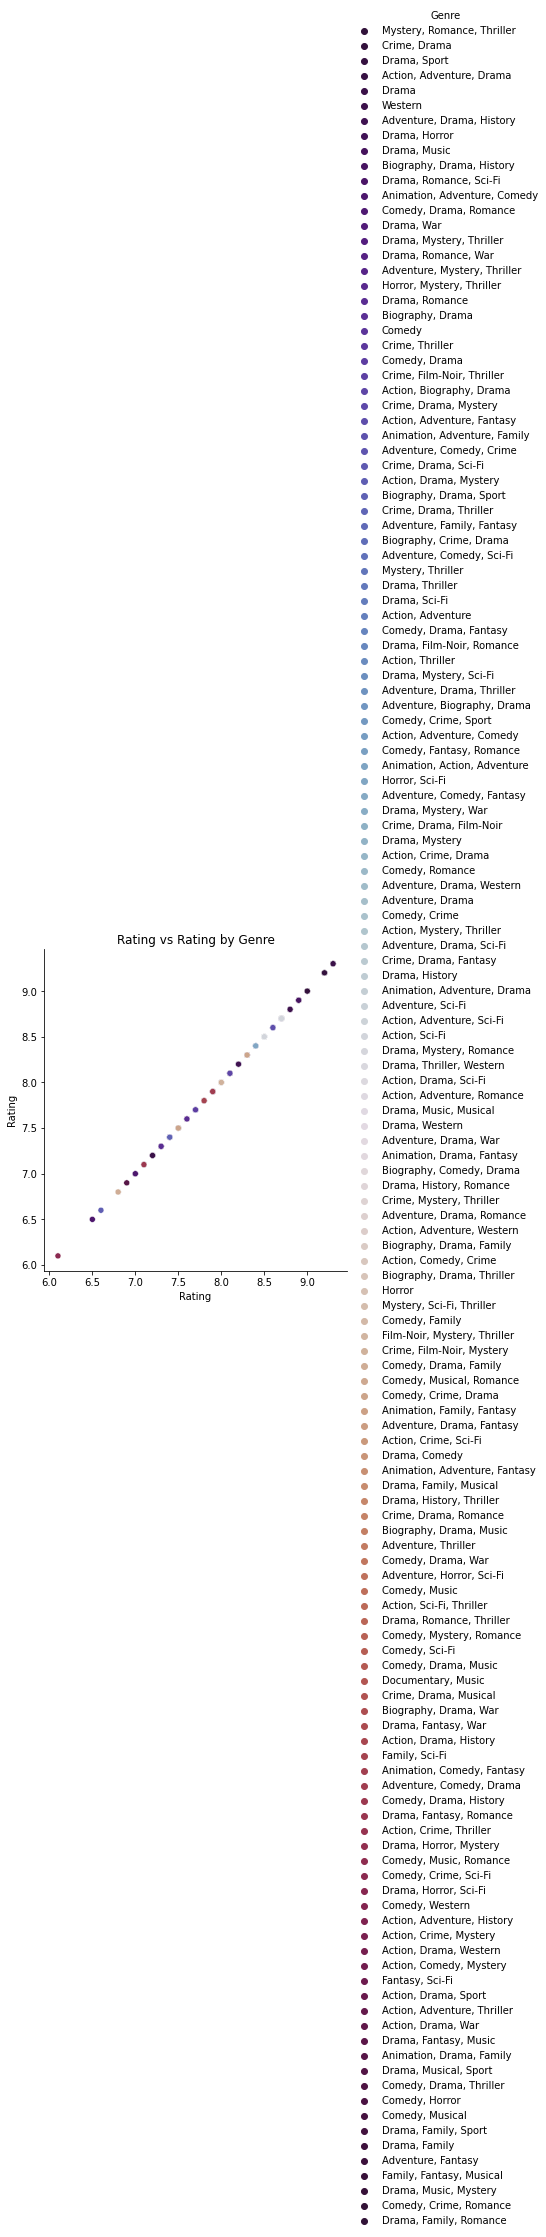

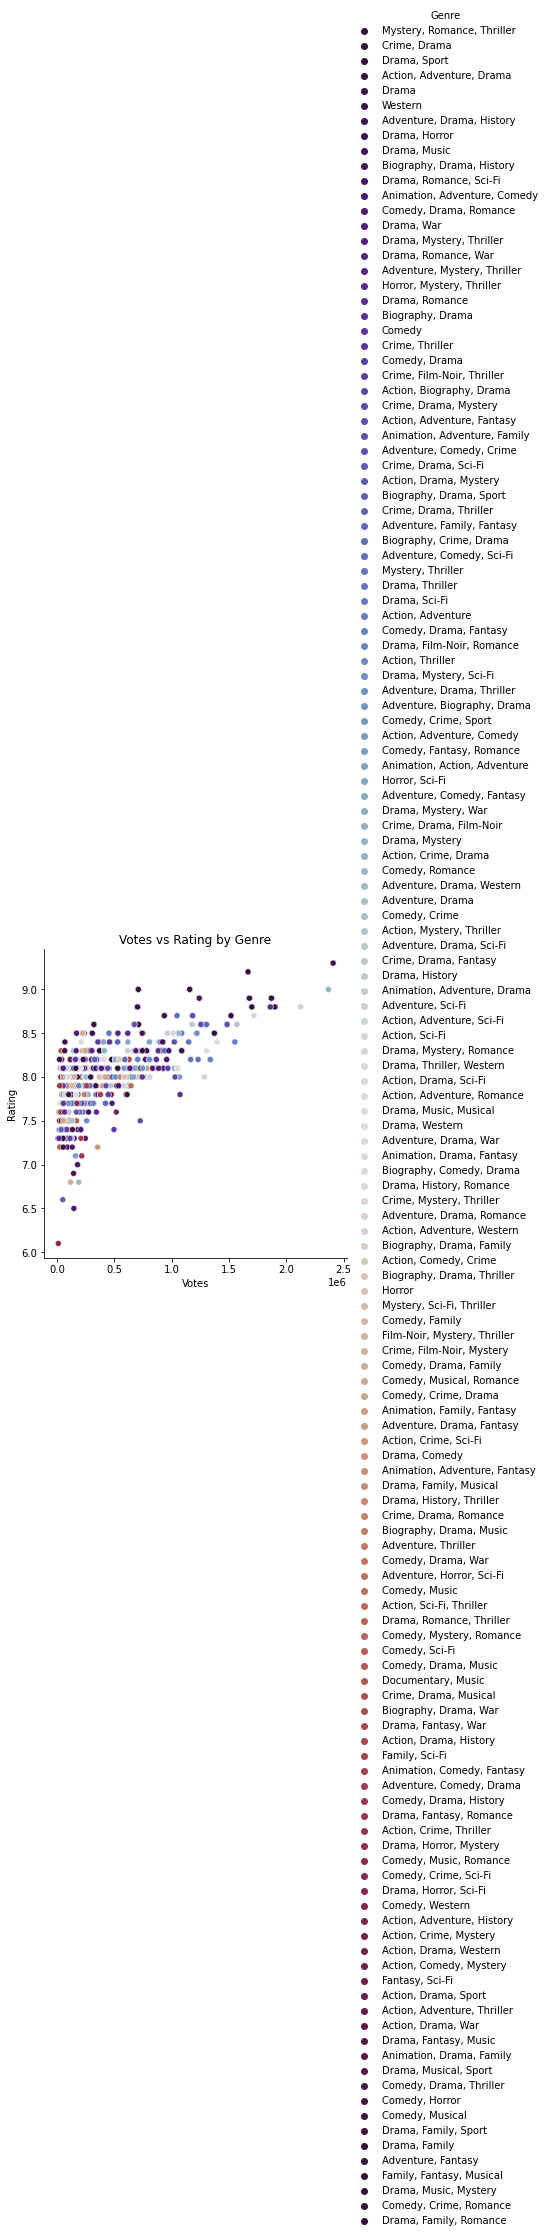

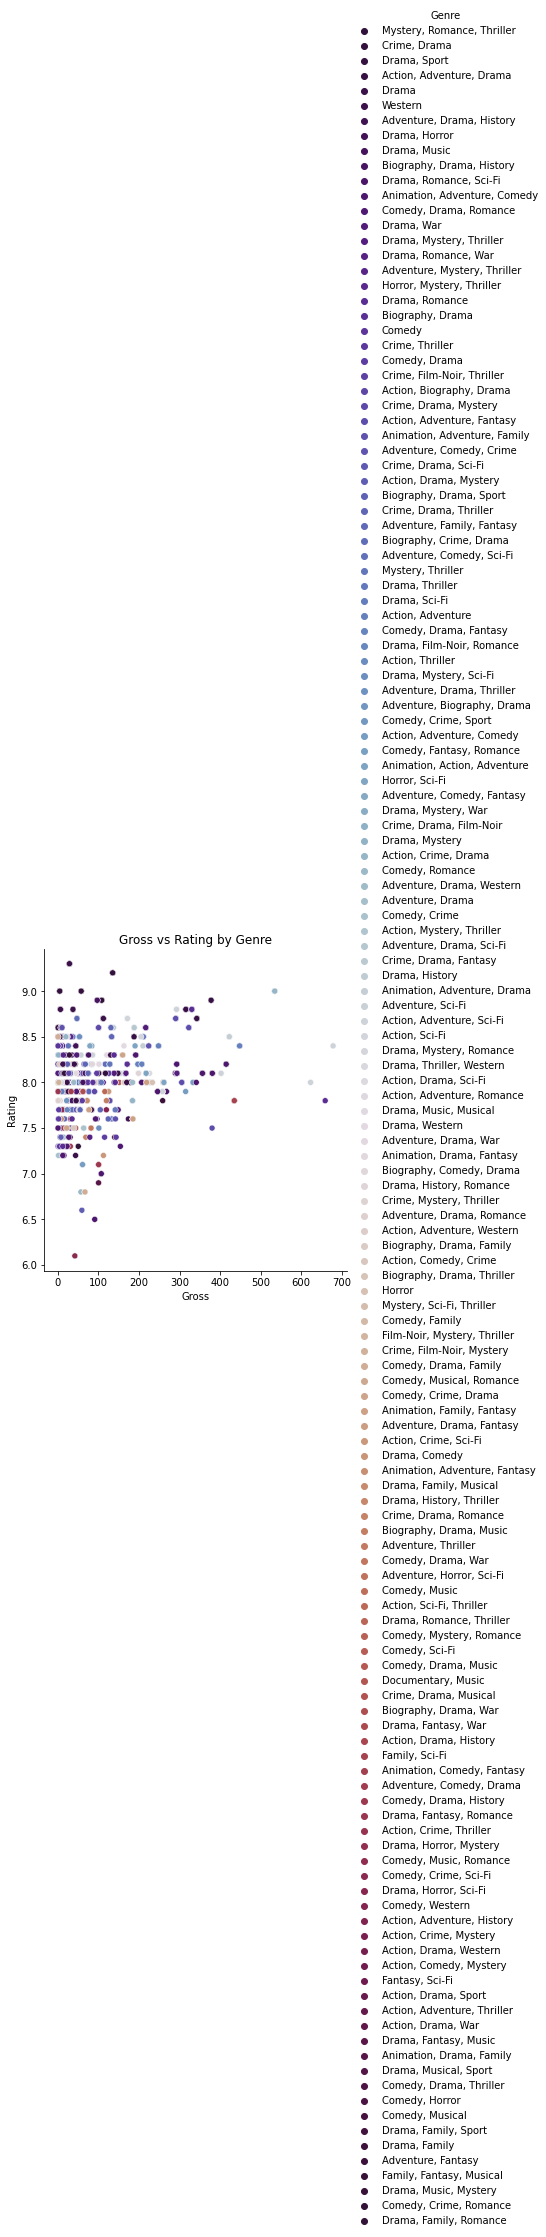

In [13]:
# call multivariate explore function from script

ex.explore_multivariate(train, 'Rating', cat_vars, cont_vars)

### Takeaways

- 2008 movies seem to have longer runtimes
- Most older movies have lower Ratings
- Gross values seem to be concentrated in the lower end with few outliers on the upper end
- movie of Action and Drama genres seem to have a lot of votes

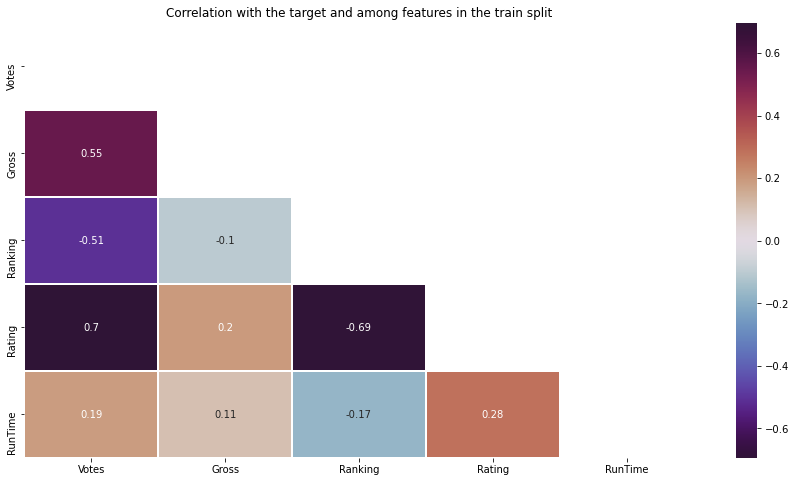

In [15]:
cols = ['Votes', 'Gross', 'Ranking', 'Rating', 'RunTime']

ex.create_heatmap(train, cols)

### Takeaways

- highest correlation is negative correlation of -.64 of ranking with rating 
    - Higher ranking, lower rating 
- Number of votes has the next highest correlation of 0.63 with rating 
    - more votes, higher rating
- Number of votes is also correlated with gross and ranking
- There does not seem to be much correlation among the other variables

### Statistical testing

### Do movies with runtime less than 150 minutes have lower ratings?

H0: Mean rating for movies with runtime less than 150mins is equivalent to those with more than 150mins runtime

Ha: Mean rating for movies with runtime less than 150mins is lower than those with more than 150mins runtime

For a 1-tailed test where our alternative hypothesis is testing for "lower than", we evaluate 𝑝/2 < 𝛼 and 𝑡 > 0.


In [40]:
alpha = 0.05 

t, p = stats.ttest_ind(train[train.RunTime < 150].Rating, train[train.RunTime > 150].Rating)


In [41]:
p/2 < alpha

True

- Since p/2 is less than alpha, we reject the null and can say that movies with runtimes lower than 150mins have lower ratings.

In [42]:
# quick look at train split

train.head()

,Ranking,IMDByear,IMDBlink,Title,Date,RunTime,Genre,Rating,Score,Votes,Gross,Director,Cast1,Cast2
4312,63,2013,/title/tt0052357/,Vertigo,1958,128,"Mystery, Romance, Thriller",8.3,100.0,372617,3.20,Alfred Hitchcock,James Stewart,Kim Novak
3173,174,2008,/title/tt0086250/,Scarface,1983,170,"Crime, Drama",8.3,65.0,762028,45.60,Brian De Palma,Al Pacino,Michelle Pfeiffer
3461,212,2009,/title/tt0075148/,Rocky,1976,120,"Drama, Sport",8.1,70.0,530154,117.24,John G. Avildsen,Sylvester Stallone,Talia Shire
2173,174,2004,/title/tt0172495/,Gladiator,2000,155,"Action, Adventure, Drama",8.5,67.0,1372239,187.71,Ridley Scott,Russell Crowe,Joaquin Phoenix
5699,200,2018,/title/tt0405159/,Million Dollar Baby,2004,132,"Drama, Sport",8.1,86.0,647713,100.49,Clint Eastwood,Hilary Swank,Clint Eastwood


In [17]:
# assign X and y variables in all our split dfs

X_train = train.drop(columns = ['IMDBlink', 'Title', 'Genre','Director','Cast1','Cast2'])
y_train = train[['Rating']]

X_validate = validate.drop(columns = ['IMDBlink', 'Title', 'Genre','Director','Cast1','Cast2'])
y_validate = validate[['Rating']]

X_test = test.drop(columns = ['IMDBlink', 'Title', 'Genre','Director','Cast1','Cast2'])
y_test = test[['Rating']]

- We dropped the object columns so as to only include numeric columns in our models.

In [18]:
# quick check of our split dfs

X_train.shape, X_validate.shape, X_test.shape

((2739, 8), (1175, 8), (979, 8))

Ranking    -0.694265
Date       -0.006697
Score       0.133331
Gross       0.196959
RunTime     0.284942
IMDByear    0.309065
Votes       0.696338
Rating      1.000000
Name: Rating, dtype: float64

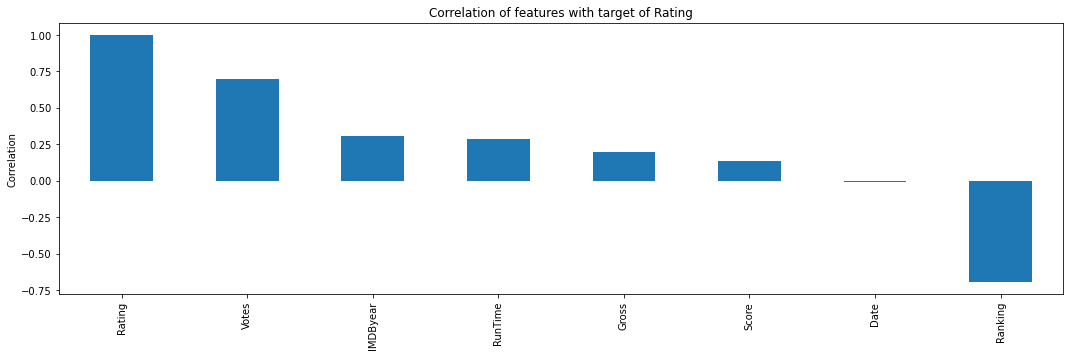

In [19]:
# correlation of features with target

plt.title('Correlation of features with target of Rating')
plt.ylabel('Correlation')
train.corr().Rating.sort_values(ascending=False).plot(kind='bar', figsize=(18,5))
train.corr().Rating.sort_values()

- Number of votes and Ranking seem to have the highest correlation with the target variable of Rating.
- Lowest correlation with target is of Date.

In [21]:
# quick look at X train 

X_train.head()

,Ranking,IMDByear,Date,RunTime,Rating,Score,Votes,Gross
4312,63,2013,1958,128,8.3,100.0,372617,3.20
3173,174,2008,1983,170,8.3,65.0,762028,45.60
3461,212,2009,1976,120,8.1,70.0,530154,117.24
2173,174,2004,2000,155,8.5,67.0,1372239,187.71
5699,200,2018,2004,132,8.1,86.0,647713,100.49


### Modeling

In [22]:
# Establish baseline

# 1. Predict mean rating 
rating_pred_mean = y_train.Rating.mean()
y_train['rating_pred_mean'] = rating_pred_mean
y_validate['rating_pred_mean'] = rating_pred_mean

# 2. Predict median rating
rating_pred_median = y_train.Rating.median()
y_train['rating_pred_median'] = rating_pred_median
y_validate['rating_pred_median'] = rating_pred_median

# 3. RMSE of rating_pred_mean
rmse_train = mean_squared_error(y_train.Rating, y_train.rating_pred_mean) ** 0.5
rmse_validate = mean_squared_error(y_validate.Rating, y_validate.rating_pred_mean) ** 0.5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of tv_pred_median
rmse_train1 = mean_squared_error(y_train.Rating, y_train.rating_pred_median) ** .5
rmse_validate1 = mean_squared_error(y_validate.Rating, y_validate.rating_pred_median) ** .5
print('-----------')
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train1, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate1, 2))

RMSE using Mean
Train/In-Sample:  0.34 
Validate/Out-of-Sample:  0.33
-----------
RMSE using Median
Train/In-Sample:  0.35 
Validate/Out-of-Sample:  0.34


### Takeaways 

- The goal is to have the RMSE as low as possible on the train split and a small drop, if any, in RMSE between train and validate sets.

- While the RMSE is close in value for both mean and median with similar drop off, we will use the median Rating as our baseline since median is more resistant to outliers.

- This baseline RMSE of 0.34 is what our models will try to beat.

In [23]:
# add the median baseline to a df to help evaluate all models side by side

metric_df = pd.DataFrame(data=[{
    'model': 'median_baseline',
    'rmse_outofsample': rmse_validate,
    'r^2_outofsample': explained_variance_score(y_validate.Rating, y_validate.rating_pred_median)}])


In [24]:
# look at metrics df

metric_df

,model,rmse_outofsample,r^2_outofsample
0,median_baseline,0.331971,0.0


### OLS Linear Regression Model

In [25]:
# create the model object
# 
# make the thing
# 
lm = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the thing
# use only the features we selected
lm.fit(X_train, y_train.Rating)

# predict train
# 
# use the thing!
# 
y_train['rating_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Rating, y_train.rating_pred_lm) ** (1/2)

# predict validate
y_validate['rating_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Rating, y_validate.rating_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  4.2244523796667566e-15 
Validation/Out-of-Sample:  4.153175086547869e-15


In [26]:
# add model's performance to metric df

metric_df = metric_df.append(
    {
    'model': 'OLS lm',
    'rmse_outofsample': rmse_validate,
        'r^2_outofsample': explained_variance_score(y_validate.Rating, y_validate.rating_pred_lm)}, ignore_index=True)


In [27]:
metric_df

,model,rmse_outofsample,r^2_outofsample
0,median_baseline,3.319710e-01,0.0
1,OLS lm,4.153175e-15,1.0


### Lasso + Lars Model

In [28]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data using only selected features. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series
lars.fit(X_train, y_train.Rating)

# predict train
y_train['rating_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Rating, y_train.rating_pred_lars) ** 0.5

# predict validate
y_validate['rating_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Rating, y_validate.rating_pred_lars) ** 0.5

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.3394692950725153 
Validation/Out-of-Sample:  0.3319709883759729


In [29]:
# add model to metric df

metric_df = metric_df.append(
    {
    'model': 'LassoLars alpha 1',
    'rmse_outofsample': rmse_validate,
    'r^2_outofsample': explained_variance_score(y_validate.Rating, y_validate.rating_pred_lars)}, ignore_index=True)

In [30]:
metric_df

,model,rmse_outofsample,r^2_outofsample
0,median_baseline,3.319710e-01,0.0
1,OLS lm,4.153175e-15,1.0
2,LassoLars alpha 1,3.319710e-01,0.0


### Tweedie Regressor GLM

In [31]:
# create the model object
glm = TweedieRegressor(power=0, alpha=1)

# fit the model to our training data using only selected features. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series

glm.fit(X_train, y_train.Rating)

# predict train
y_train['rating_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Rating, y_train.rating_pred_glm) ** 0.5


# predict validate
y_validate['rating_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Rating, y_validate.rating_pred_glm) ** 0.5


print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  0.17353093229789324 
Validation/Out-of-Sample:  0.1720721379079987


In [32]:
# add model to metric df

metric_df = metric_df.append(
    {
    'model': 'Tweedie GLM power 1',
    'rmse_outofsample': rmse_validate,
    'r^2_outofsample': explained_variance_score(y_validate.Rating, y_validate.rating_pred_glm)}, ignore_index=True)

In [33]:
metric_df

,model,rmse_outofsample,r^2_outofsample
0,median_baseline,3.319710e-01,0.000000
1,OLS lm,4.153175e-15,1.000000
2,LassoLars alpha 1,3.319710e-01,0.000000
3,Tweedie GLM power 1,1.720721e-01,0.731324


### Polynomial Regression Model

For this model, we first need to change our features such that they can be used in polynomial regression. To do this we will use a degree of 2 to square our predictors and use them in the model.

In [34]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled features
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)


In [35]:
#create the model object
# 
# make the thing
# 
pm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the thing
# 
pm.fit(X_train_degree2, y_train.Rating)

# predict train
# 
# use the thing!
# 
y_train['rating_pred_pm'] = pm.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.Rating, y_train.rating_pred_pm) ** (1/2)

# predict validate
y_validate['rating_pred_pm'] = pm.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.Rating, y_validate.rating_pred_pm) ** (1/2)

print("RMSE for PolynomialRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for PolynomialRegression
Training/In-Sample:  2.9474997564522346e-14 
Validation/Out-of-Sample:  2.9413194895991444e-14


In [36]:
# add model to metric df

metric_df = metric_df.append(
    {
    'model': 'PolyReg Model',
    'rmse_outofsample': rmse_validate,
    'r^2_outofsample': explained_variance_score(y_validate.Rating, y_validate.rating_pred_pm)}, ignore_index=True)
metric_df

,model,rmse_outofsample,r^2_outofsample
0,median_baseline,3.319710e-01,0.000000
1,OLS lm,4.153175e-15,1.000000
2,LassoLars alpha 1,3.319710e-01,0.000000
3,Tweedie GLM power 1,1.720721e-01,0.731324
4,PolyReg Model,2.941319e-14,1.000000


#### Takeaways

- All models beat the baseline R-squared
- Lasso Lars model had the same RMSE as the baseline but a negative R squared
- The best performing model is the OLS Linear Regression Model with RMSE of 4.153175e-15 (realistically 0) and R squared of 1. We can see that the model is off by 4.048509e-15 points while the baseline is off by 0.03 points for a movie's rating. The model also explains 100% of the variance in movie ratings while the baseline explains 0%.
- We will fit the OLS Linear Regression Model on our test data and evaluate its performance.

### Fit best performing model on test split


In [37]:
# predict on test
y_test['rating_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.Rating, y_test.rating_pred_lm) ** 0.5
print("RMSE for Model using OLS Linear Regression\nOut-of-Sample Performance: ", rmse_test)

RMSE for Model using OLS Linear Regression
Out-of-Sample Performance:  4.347647869435053e-15


In [38]:
metric_df = metric_df.append(
    {
    'model': 'Test',
    'rmse_outofsample': rmse_test,
    'r^2_outofsample': explained_variance_score(y_test.Rating, y_test.rating_pred_lm)}, ignore_index=True)

In [39]:
metric_df

,model,rmse_outofsample,r^2_outofsample
0,median_baseline,3.319710e-01,0.000000
1,OLS lm,4.153175e-15,1.000000
2,LassoLars alpha 1,3.319710e-01,0.000000
3,Tweedie GLM power 1,1.720721e-01,0.731324
4,PolyReg Model,2.941319e-14,1.000000
5,Test,4.347648e-15,1.000000


### Takeaways

Our Model rmse increased very slightly but not enough to indicate that the model was overfit. The model's R-squared remained at 100% 

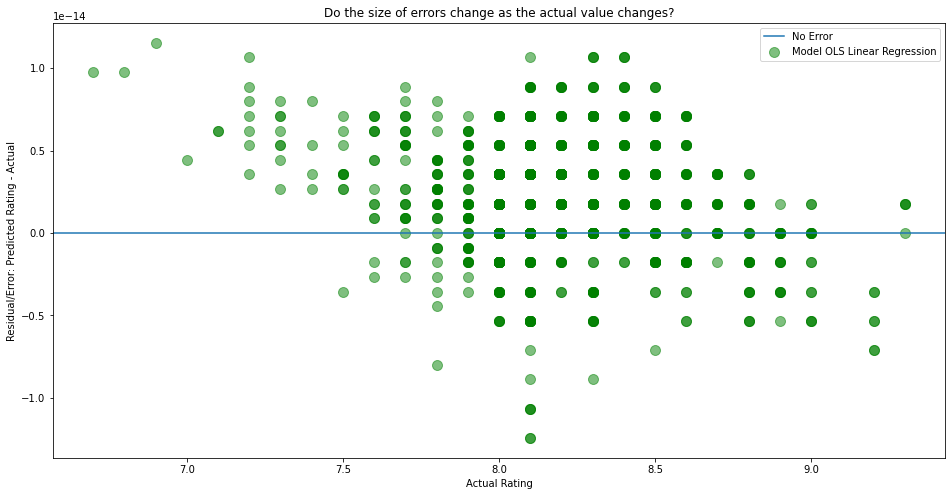

In [44]:
# plot the residuals for the best performing model

plt.figure(figsize=(16,8))
plt.axhline(label="No Error")

plt.scatter(y_validate.Rating, y_validate.rating_pred_lm - y_validate.Rating, 
            alpha=.5, color="green", s=100, label="Model OLS Linear Regression")
plt.legend()
plt.xlabel("Actual Rating")
plt.ylabel("Residual/Error: Predicted Rating - Actual")
plt.title("Do the size of errors change as the actual value changes?")

plt.show()

### Takeaways

- The residuals do not seem to have a pattern which is good 
- The residuals seem to be slightly higher for higher ratings
- Model performance deteriorates for ratings between 8.1 and 8.5

### Conclusion & Next Steps

- The Linear Regression can predict all of the variance in Ratings and has a very low RMSE 
- With our current models, we can say that Ranking, year, Date, runtime, score, votes and gross value can predict a movie's Rating well.
- With more time, we could remove outliers and evaluate the impact on model performance as well as try scaling methods.